# I&E Study 7.1 Automated Stakeholder Analysis for Hedera


In this Notebook we will demonstrate how to scrape, clean, analyse and visualise data from different resources to do stakeholder analysis for Hedera.

In [42]:
import warnings

warnings.filterwarnings("ignore", category=DeprecationWarning)

## Scraping

First we will gather data from the website https://seepnetwork.org. More specifically we will collect the data of the members of the seepnetwork.

For this we will define a method that will download the data, or if we already have the file in our local folder we just load it from there to reduce network traffic towards there website.

In [43]:
import requests
import os
from pathlib import Path
from bs4.element import Comment

def load_page(name, path):
    
    displayname = name.replace('https://', '').replace('http://', '').replace('/', '')
    full_path = path+displayname
    
    content = ""
    
    try:
        with open(full_path, 'r', encoding='utf-8') as f:
            content = f.read().replace("\n", "").replace("\t", "")
    except (OSError, IOError) as e:
        url = name
        if "http" not in url:
            url = "http://" + url
        print("parsing: " + url)
        response = requests.get(url)
        directory = os.path.dirname(full_path)
        Path(directory).mkdir(parents=True, exist_ok=True)
        open(full_path, 'wb').write(response.content)
        content = response.content
        
    return content 

def tag_visible(element):
    if element.parent.name in ['style', 'script', 'head', 'title', 'meta', '[document]']:
        return False
    if isinstance(element, Comment):
        return False
    return True

First we will scrape the main page.

In [44]:
file_dir = "webpages/"
parent_page = "https://seepnetwork.org"
main_content = load_page(parent_page + "/Profiles", file_dir)

parsing: https://seepnetwork.org/Profiles


Next we will get all of the links to the individual member profile pages. Therefor we select all of the elements and extract the href field.

In [45]:
from bs4 import BeautifulSoup

bs = BeautifulSoup(main_content)

sub_links = []
for link in bs.select(".mapListViewItem .button.border.blue a"):
    sub_links.append(link["href"])
    
print(f'We found {len(sub_links)} members.')

We found 96 members.


To get the members data we download the profile pages and parse the needed fields into an array for further processing.

In [46]:
data = []

for link in sub_links:
    content = load_page(parent_page+link, file_dir)
    bs = BeautifulSoup(content)
    parts = bs.select(".sidebar.left")
    
    name = parts[0].select_one("h3").string.strip()
#     years_of_membership = parts[0].select_one(".sidebarRight > p").string[0]
    location = parts[0].select_one(".sidebarRight .twoColLeft > p").contents[-1].strip()
    website = parts[0].select_one(".sidebarRight .twoColRight a")['href'].strip()
    org_type = parts[0].select_one(".sidebarRight .twoColRight > p").contents[-1].strip()
    mission_statement = parts[1].select(".sidebarRight > p")[0].contents[-1].strip()
    countries_of_involvement = parts[1].select(".sidebarRight > p")[1].contents[-1].strip()
    practice_areas = parts[1].select(".sidebarRight > p")[2].contents[-1].strip()
    website_content = ""
    error_loading_website = False
    try:
        website_html = load_page(website, file_dir)
        if len(website_html) > 7232460:
            raise Exception("Website to large")
        texts = BeautifulSoup(website_html).findAll(text=True)
        visible_texts = filter(tag_visible, texts)  
        website_content = u" ".join(t.strip() for t in visible_texts)
    except Exception as err:
        error_loading_website = True
        print("unable to parse website content: " + website, err)
    data.append([name, location, website, org_type, mission_statement, countries_of_involvement, practice_areas, website_content, error_loading_website])

parsing: https://seepnetwork.org/Member-Details/access-to-finance-rwanda
parsing: http://www.afr.rw/
parsing: https://seepnetwork.org/Member-Details/aemfi-association-of-ethiopian-microfinance-institutions
parsing: http://www.aemfi-ethiopia.org/
parsing: https://seepnetwork.org/Member-Details/aga-khan-foundation-usa
parsing: https://www.akfusa.org/
parsing: https://seepnetwork.org/Member-Details/ama-afghanistan-microfinance-association
parsing: http://www.ama.org.af/
parsing: https://seepnetwork.org/Member-Details/amfa-azerbaijan-micro-finance-association
parsing: http://www.amfa.az/
parsing: https://seepnetwork.org/Member-Details/amfi-kenya
parsing: http://www.amfi-kenya.com
unable to parse website content: www.amfi-kenya.com HTTPConnectionPool(host='www.amfi-kenya.com', port=80): Max retries exceeded with url: / (Caused by NewConnectionError('<urllib3.connection.HTTPConnection object at 0x10a0c6370>: Failed to establish a new connection: [Errno 8] nodename nor servname provided, or n

parsing: http://www.oxfamamerica.org/
parsing: https://seepnetwork.org/Member-Details/pact-inc
parsing: http://www.pactworld.org/
parsing: https://seepnetwork.org/Member-Details/pci-project-concern-international
parsing: http://www.pciglobal.org
parsing: https://seepnetwork.org/Member-Details/plan-international
parsing: http://plan-international.org/
parsing: https://seepnetwork.org/Member-Details/PMN
parsing: http://www.microfinanceconnect.info
parsing: https://seepnetwork.org/Member-Details/prodesarrollo-finanzas-y-microempresa
parsing: http://www.prodesarrollo.org/
unable to parse website content: http://www.prodesarrollo.org/ exceptions must derive from BaseException
parsing: https://seepnetwork.org/Member-Details/rim-burundi-r-seau-des-institutions-de-microfinance-au-burundi
parsing: http://www.rimburundi.org/
parsing: https://seepnetwork.org/Member-Details/RTI
parsing: https://www.rti.org/
parsing: https://seepnetwork.org/Member-Details/save-the-children
parsing: http://www.savet

In [52]:
# One Example
data[3]

['AMA - Afghanistan Microfinance Association',
 'Afghanistan',
 'http://www.ama.org.af/',
 'National, Regional, Global Network',
 'To build an inclusive, sustainable and responsible development finance sector through policy advocacy, knowledge management, coordination & networking, and capacity building.',
 'Afghanistan',
 'Financial Inclusion',
 '                                                 Skip to content            About Us   Overview  Board of Directors  Senior Management  Donors    Services   Lobby & Advocacy  Knowledge Management  Coordination  Capacity Building    Membership   Current Members   MFIs  MFBs  FIs  CSPIs    Membership Criteria  Membership Benefits    Projects   Ongoing   USAID – Promote   A2F Roundtables  Training Program    Switch Asia    Completed   USAID – ACE II      Publications   MicroView Report  MicroMag  E-Newsletter  Annual Report  Other Publications  RFPs & RFQs    News & Events   Latest News  Events Calendar  Press Release    Jobs   Job Portal  Staff

Finally we write the parsed information into a csv file which can later be used as an input for the machine learning algorithms.

In [48]:
import csv
wtr = csv.writer(open ('member_data.csv', 'w', encoding='utf-8'), delimiter=',', lineterminator='\n')
for member in data :
    wtr.writerow (member)

## Analyzing the data


### Load Data in Pandas DataFrame 

First of all we load all data into a pandas data frame. 

In [8]:
import pandas as pd

df = pd.read_csv(
    "member_data.csv",
    header=None,
    names=[
        "name",
        "location",
        "website",
        "org_type",
        "mission_statement",
        "countries_of_involvement",
        "practice_areas",
    ],
)

For each organisation with have name, location, website link, organization type, their mission statement, countries of involvement, practice areas.

In [9]:
pd.set_option('display.max_colwidth',200)
df.head(5)

,name,location,website,org_type,mission_statement,countries_of_involvement,practice_areas
0,Access to Finance Rwanda,Rwanda,http://www.afr.rw/,Development Organization,"Low income Rwandans, especially women and youth, benefit from use of a variety of appropriate financial services",Rwanda,"Fragile & Conflict-affected Environments, Gender Equality, Health, Housing"
1,AEMFI - Association of Ethiopian Microfinance Institutions,Ethiopia,http://www.aemfi-ethiopia.org/,"National, Regional, Global Network","To enhance the capacity of microfinance institutions and financial cooperatives to deliver financials services to urban and rural households through technical assistance, human capital development...",Ethiopia,Education; Environment & Climate; Financial Consumer Protection; Financial Inclusion; Housing; Livelihoods; MSME Development; Rural & Agricultural Development; Savings-Led Community Finance; Urban...
2,Aga Khan Foundation USA,United States,https://www.akfusa.org/,Development Organization,"Promote social development, primarily in low income countries.",Afghanistan; Bangladesh; India; Kenya; Kyrgyzstan; Madagascar; Mali; Mozambique; Pakistan; Tajikistan; Tanzania,"Education; Financial Consumer Protection; Food Security & Nutrition; Gender Equality; Rural & Agricultural Development; Urban Development; WASH (Water, Sanitation, & Hygiene); Youth & Children"
3,AMA - Afghanistan Microfinance Association,Afghanistan,http://www.ama.org.af/,"National, Regional, Global Network","To build an inclusive, sustainable and responsible development finance sector through policy advocacy, knowledge management, coordination & networking, and capacity building.",Afghanistan,Financial Inclusion
4,AMFA - Azerbaijan Micro-Finance Association,Azerbaijan,http://www.amfa.az/,"National, Regional, Global Network",To strengthen the capacity of micro-finance institutions and to promote effective collective action in advancing the interests of the micro-finance community and its clients.,Azerbaijan,Financial Consumer Protection; Financial Inclusion; Gender Equality; MSME Development


In [10]:
from pandas_profiling import ProfileReport

df_selected = df.loc[:, ["name", "org_type", "countries_of_involvement", "location"]]
profile = ProfileReport(
    df_selected,
    title="Pandas Profiling Report",
    correlations=None,
    samples=None,
    missing_diagrams=None,
    duplicates=None,
)
profile.to_notebook_iframe()

### Most Common Practice Areas

Each of the members is assigned to several practice areas. We take a look at which practice areas are most common among the members.

In [11]:
# Practice area dict
practice_areas = {}

# Add practice areas to dictionary
def count_areas(areas):
    for area in areas:
        if area in practice_areas:
            practice_areas[area] += 1
        else:
            practice_areas[area] = 1  

In [12]:
import numpy as np
import operator
# Load the regular expression library
import re

# Convert practice areas string to list of areas
df["practice_areas"] = df["practice_areas"].replace(np.nan, '', regex=True)
df["practice_areas"] =  df.apply(lambda x: re.sub(r'\([^)]*\)', '',x["practice_areas"]), axis=1)
df["practice_areas"] = df.apply(lambda x: [area.strip() for area in re.split('; |,',x["practice_areas"])], axis=1)
df.apply(lambda x: count_areas(x["practice_areas"]), axis=1)

# Print 10 most commom practice areas
dict(sorted(practice_areas.items(), key=operator.itemgetter(1), reverse=True)[:10])

{'Financial Inclusion': 73,
 'Gender Equality': 55,
 'Livelihoods': 49,
 'Market Systems Development': 47,
 'Savings-Led Community Finance': 46,
 'Youth & Children': 44,
 'MSME Development': 42,
 'Rural & Agricultural Development': 40,
 'Education': 37,
 'Food Security & Nutrition': 30}

### Mission Statement Modeling

We use regular expression for cleaning the mission statement. We delete all non word characters and replace all uppercase letters with lowercase letters. 

In [13]:
# Remove punctuation
df["mission_statement_processed"] = df["mission_statement"].map(
    lambda x: re.sub("[,\.!?]", "", x)
)
# Convert the tex to lowercase
df["mission_statement_processed"] = df["mission_statement_processed"].map(lambda x: x.lower())
# Print out the first rows
df[["mission_statement", "mission_statement_processed"]].head()

,mission_statement,mission_statement_processed
0,"Low income Rwandans, especially women and youth, benefit from use of a variety of appropriate financial services",low income rwandans especially women and youth benefit from use of a variety of appropriate financial services
1,"To enhance the capacity of microfinance institutions and financial cooperatives to deliver financials services to urban and rural households through technical assistance, human capital development...",to enhance the capacity of microfinance institutions and financial cooperatives to deliver financials services to urban and rural households through technical assistance human capital development ...
2,"Promote social development, primarily in low income countries.",promote social development primarily in low income countries
3,"To build an inclusive, sustainable and responsible development finance sector through policy advocacy, knowledge management, coordination & networking, and capacity building.",to build an inclusive sustainable and responsible development finance sector through policy advocacy knowledge management coordination & networking and capacity building
4,To strengthen the capacity of micro-finance institutions and to promote effective collective action in advancing the interests of the micro-finance community and its clients.,to strengthen the capacity of micro-finance institutions and to promote effective collective action in advancing the interests of the micro-finance community and its clients


#### Word Cloud

To determine the most common words in the mission statements, we created a Wordcloud. 

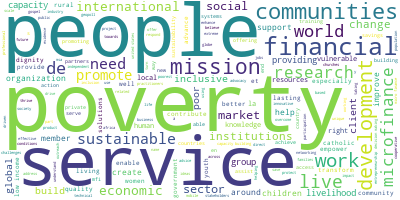

In [14]:
# Import the wordcloud library
from wordcloud import WordCloud
# Join the different processed titles together.
long_string = ','.join(list(df['mission_statement_processed'].values))
# Create a WordCloud object
wordcloud = WordCloud(background_color="white", max_words=5000, contour_width=3, contour_color='steelblue')
# Generate a word cloud
wordcloud.generate(long_string)
# Visualize the word cloud
wordcloud.to_image()

#### 10 Most Common Features

We also used the CountVectorizer from sklearn to plot the 10 most common words in the mission statements.

In [15]:
# Load the library with the CountVectorizer method
from sklearn.feature_extraction.text import CountVectorizer
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
%matplotlib inline

In [16]:
# Helper function
def plot_10_most_common_words(count_data, count_vectorizer):
    import matplotlib.pyplot as plt
    words = count_vectorizer.get_feature_names()
    total_counts = np.zeros(len(words))
    for t in count_data:
        total_counts+=t.toarray()[0]
    
    count_dict = (zip(words, total_counts))
    count_dict = sorted(count_dict, key=lambda x:x[1], reverse=True)[:10]
    words = [w[0] for w in count_dict]
    counts = [w[1] for w in count_dict]
    x_pos = np.arange(len(words)) 
    # print(words)
    plt.figure(2, figsize=(15, 15/1.6180))
    plt.subplot(title='10 most common words')
    sns.set_context("notebook", font_scale=1.25, rc={"lines.linewidth": 2.5})
    sns.barplot(x=x_pos, y=counts, palette='husl')
    plt.xticks(x_pos, words, rotation=90) 
    plt.xlabel('words')
    plt.ylabel('counts')
    plt.show()

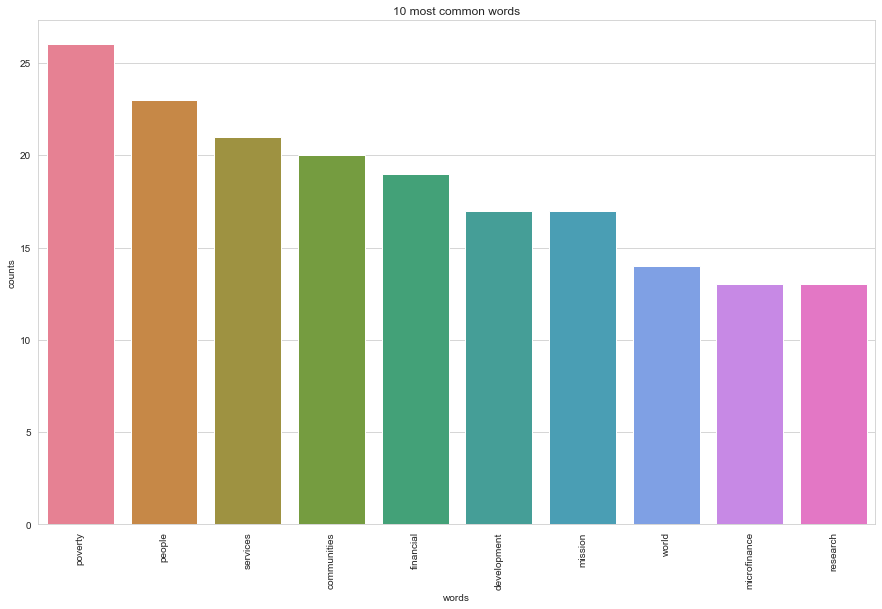

In [17]:
# Initialise the count vectorizer with the English stop words
count_vectorizer = CountVectorizer(stop_words='english')
# Fit and transform the processed titles
count_data = count_vectorizer.fit_transform(df['mission_statement_processed'])
# Visualise the 10 most common words
plot_10_most_common_words(count_data, count_vectorizer)

#### LDA

In order to get an even better understanding of the members mission, we use the Latent Dirichlet allocation algorithm. This method groups words into topics and rank the words according to their probability.

We set the number of topics to 5 and want to get the 10 most common words in those topics. 

In [18]:
# Load the LDA model from sk-learn
from sklearn.decomposition import LatentDirichletAllocation as LDA

In [19]:
# Helper function
def print_topics(model, count_vectorizer, n_top_words):
    words = count_vectorizer.get_feature_names()
    for topic_idx, topic in enumerate(model.components_):
        print(f"\nTopic #{topic_idx+1:d}:")
        print(" ".join([words[i]
                        for i in topic.argsort()[:-n_top_words - 1:-1]]))

In [20]:
# Tweak the two parameters below
number_topics = 5
number_words = 10
# Create and fit the LDA model
lda = LDA(n_components=number_topics, max_iter=100, random_state=100, n_jobs=-1)
lda.fit(count_data)
# Print the topics found by the LDA model
print("Topics found via LDA:")
print_topics(lda, count_vectorizer, number_words)

Topics found via LDA:

Topic #1:
international youth poverty services development groups enable building economic vulnerable

Topic #2:
microfinance mission build sustainable inclusive services sector capacity promote financial

Topic #3:
communities financial needs research global children services clients change sector

Topic #4:
people et des sustainable savings services research africa country poverty

Topic #5:
poverty people world poor social mission development communities economic financial


#### PyLDAvis

We also tried a Python library for interactive topic model visualization called pyLDAvis.

In [21]:
import pyLDAvis
from pyLDAvis import sklearn as sklearn_lda

In [22]:
%%time
# LDAvis_data_filepath = os.path.join('./ldavis_prepared_'+str(number_topics))
LDAvis_prepared = sklearn_lda.prepare(lda, count_data, count_vectorizer)

D:\soft\Anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Wall time: 2.95 s


In [23]:
pyLDAvis.enable_notebook()
pyLDAvis.display(LDAvis_prepared)

D:\soft\Anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
